# 为二分类训练划分数据集

In [3]:
import os
import sys
import tarfile
import collections
import torch.utils.data as data
import shutil
import numpy as np

from PIL import Image
from torchvision.datasets.utils import download_url, check_integrity

### 解码voc label

In [ ]:
def voc_cmap(N=256, normalized=False):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap
cmap=voc_cmap()

### 图片路径与数据集目录

In [121]:
root='/home/lulu/Dataset/'
voc2012='VOCdevkit/VOC2012'
divide_data=1000
voc_root = os.path.join(root, voc2012)
image_dir = os.path.join(voc_root, 'JPEGImages')
seed=15
Nclass=21

### 训练集/测试集 （二选一执行）

In [113]:
mask_dir = os.path.join(voc_root, 'SegmentationClassAug')
assert os.path.exists(mask_dir), "SegmentationClassAug not found, please refer to README.md and prepare it manually"
split_f = os.path.join(root, 'train_aug.txt')   

### 验证集 （二选一执行）

In [40]:
mask_dir = os.path.join(voc_root, 'SegmentationClass')
splits_dir = os.path.join(voc_root, 'ImageSets/Segmentation')
split_f = os.path.join(splits_dir, 'val' + '.txt')

### 获取文件路径列表

In [114]:
with open(os.path.join(split_f), "r") as f:
        file_names = [x.strip() for x in f.readlines()]
images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
masks = [os.path.join(mask_dir, x + ".png") for x in file_names]

### 训练集/测试集分割  （执行了验证集就不用执行）

In [107]:
np.random.seed(seed)
train_index = np.random.permutation(len(images))[:(-divide_data)]
test_index = np.setxor1d(train_index, np.arange(len(images)))

### 训练集 （二选一执行，且执行了验证集就不执行）

In [108]:
images = [images[j] for j in train_index]
masks = [masks[j] for j in train_index]

### 测试集  （二选一执行，且执行了验证集就不执行）

In [104]:
images = [images[j] for j in test_index]
masks = [masks[j] for j in test_index]

## 按类别分割标记数据集

In [127]:
path_list_per_class={i:[] for i in range(1,Nclass)}
for mask in masks:
    target = np.array(Image.open(mask))
    for i in range(1,Nclass):
        if i in target:
            path_list_per_class[i].append(mask)
    
path_list_per_class

{1: ['/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003275.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003177.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003176.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003154.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003111.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003034.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003012.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002992.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002930.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002851.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002751.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002673.png',
  '/home/lulu/Dataset/VOCdevkit/VOC2012/Segmentat

In [128]:
path_list_per_class[3]

['/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003276.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003213.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003171.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003163.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_003091.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002889.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002868.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002776.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002772.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002767.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002715.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011_002674.png',
 '/home/lulu/Dataset/VOCdevkit/VOC2012/SegmentationClassAug/2011

## 测试

### 测试一下读图片

In [115]:
target = Image.open(masks[15])

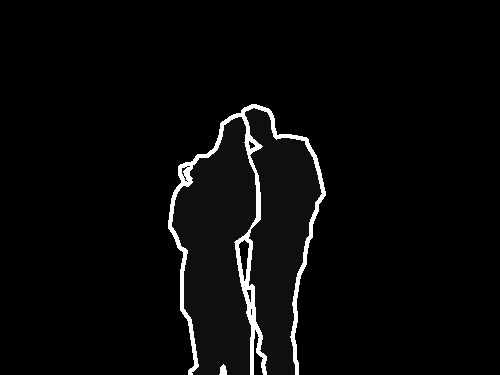

In [116]:
target

In [117]:
target = cmap[target].astype(np.uint8)

### 测试一下存储的图片长什么样

In [118]:
Image.fromarray(target).save('test_target.png')